In [26]:
#This Python 3 environment comes with many helpful analytics libraries installed
#It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Reading the complete.csv file that has confirmed covid19 cases and deaths

In [27]:
india_covid=pd.read_csv('data.csv')

In [28]:
india_covid

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated
0,2020-01-30,Kerala,10.8505,76.2711,1,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3,0,0
...,...,...,...,...,...,...,...
2700,2020-06-06,Telengana,18.1124,79.0193,3290,113,1627
2701,2020-06-06,Tripura,23.9408,91.9882,692,0,173
2702,2020-06-06,Uttar Pradesh,26.8467,80.9462,9733,257,5648
2703,2020-06-06,Uttarakhand,30.0668,79.0193,1215,11,344


In [29]:
india_covid[india_covid['Date']=='2020-06-06'].sum()

Date                         2020-06-062020-06-062020-06-062020-06-062020-0...
Name of State / UT           Andaman and Nicobar IslandsAndhra PradeshAruna...
Latitude                                                               817.498
Longitude                                                              2872.46
Total Confirmed cases                                                   228465
Death                                                                     6642
Cured/Discharged/Migrated                                               114073
dtype: object

In [30]:
india_covid.describe()

,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated
count,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000
mean,23.064751,81.043908,1685.238447,51.368946,673.656932
std,6.799257,6.596672,5895.208025,205.962806,2409.429636
min,10.850500,71.192400,1.000000,0.000000,0.000000
25%,18.112400,76.271100,9.000000,0.000000,1.000000
50%,23.610200,78.656900,67.000000,1.000000,20.000000
75%,28.704100,85.279900,887.000000,14.000000,245.000000
max,34.299600,94.727800,80229.000000,2849.000000,35156.000000


In [31]:
india_covid.columns
india_covid=india_covid.rename(columns={"Total Confirmed cases": "conf"})
india_conf=india_covid.groupby(['Date'],as_index=False).conf.sum()

In [32]:
india_conf.head

,Date,conf
0,2020-01-30,1
1,2020-01-31,1
2,2020-02-01,2
3,2020-02-02,3
4,2020-02-03,3
...,...,...
124,2020-06-02,192292
125,2020-06-03,200492
126,2020-06-04,209436
127,2020-06-05,219160


Coverting dataset for ready to be used for time series

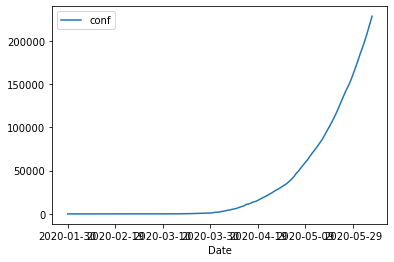

In [33]:
ts = india_conf.set_index('Date')
ts.plot()

The graph suggest that there is spike in covid cases from March 22nd onwards, suggesting Covid is increasing exponentially in India

# Loading Statsmodel for using Arima and Dickey Fuller test for stationarity

In [34]:
from statsmodels.tsa.stattools import adfuller
values_tc_india=india_covid['conf'].values
dftest=adfuller(values_tc_india)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.512242
p-value: 0.527447
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


The P value of dickey fuller test is not significant suggesting this is not a stationary time series which evident from graph before

# Checking ACF plots and effect of differencing

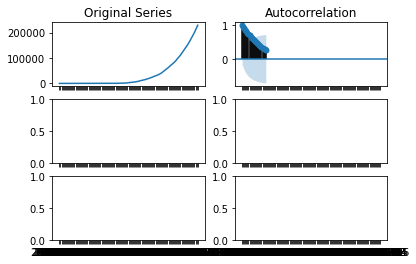

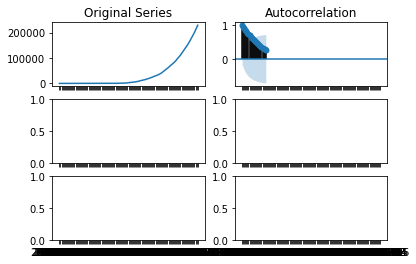

In [35]:
import numpy as np   
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')
plot_acf(ts, ax=axes[0, 1])

The ACF plot clearly shows correlation with pervious terms suggesting an AR model lets have a better plot autocorrelation_plot

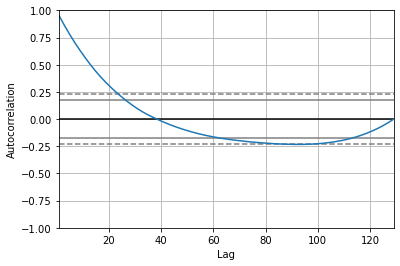

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(ts)
pyplot.show()

Here we get clear indication that upto lag 6 or 7 we have high correlation with previous values. For simplicty let us try AR(5) model firts


# Lets see if differencing 2 time makes thing stationary and somewhat removes trend

In [52]:
values_tc_india

array([   1,    1,    2, ..., 9733, 1215, 7303], dtype=int64)

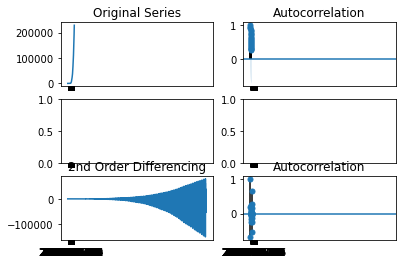

In [38]:
two_level_diff=np.diff(np.diff(values_tc_india))
axes[2, 0].plot(two_level_diff); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(two_level_diff, ax=axes[2, 1])

So we can see in the last row that differencing has made an impact converted a trend type series to a white noise a random series, Now we have an idea to put AR(5) with differencing 2 in the model hence p=5 d=2 and q=0 will be tried

# Buiding and ARIMA(5,2) model

In [42]:
ts

,conf
Date,
2020-01-30,1
2020-01-31,1
2020-02-01,2
2020-02-02,3
2020-02-03,3
...,...
2020-06-02,192292
2020-06-03,200492
2020-06-04,209436


In [39]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts, order=(5,2,0))
model_fit = model.fit()
model_fit.summary()

F:\anaconda\envs\b\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
F:\anaconda\envs\b\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D2.conf   No. Observations:                  127
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -924.654
Method:                       css-mle   S.D. of innovations            350.854
Date:                Sun, 07 Jun 2020   AIC                           1863.308
Time:                        14:47:56   BIC                           1883.217
Sample:                    02-01-2020   HQIC                          1871.397
                         - 06-06-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            73.4144     18.926      3.879      0.000      36.320     110.509
ar.L1.D2.conf    -0.3534      0.087     -4.042      0.000      -0.525      -0.182
ar.L2.D2.conf    -0.0900      0.095     -0.943      0.346      -0.277       0.097
ar.L3.D2.conf     0.0785      0.099      0.797      0.426      -0.115       0.272
ar.L4.D2.conf    -0.1195      0.100     -1.194      0.232      -0.316       0.077
ar.L5.D2.conf    -0.1757      0.095     -1.852      0.064      -0.362       0.010
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6498           -1.1349j            1.3078           -0.3328
AR.2           -0.6498           +1.1349j            1.3078            0.3328
AR.3           -1.5771           -0.0000j            1.5771           -0.5000
AR.4            1.0980           -0.9513j            1.4528           -0.1136
AR.5            1.0980           +0.9513j            1.4528            0.1136
-----------------------------------------------------------------------------
"""

Apart from Lag 3 rest lags have significant p values suggesting that current value due have an impact from previous lag values(Table2)

# Residual plots to see if they are white noise or not

In [49]:
resid

NameError: name 'resid' is not defined

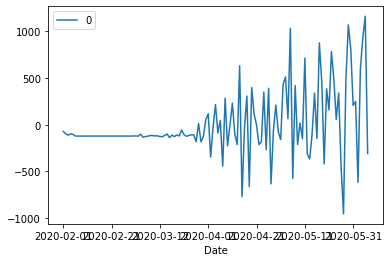

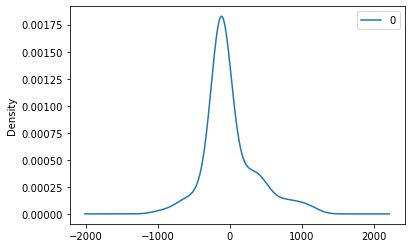

In [40]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

The density plot for residuals and residual plot suggest that randonmness of error terms , we have achieved somewhat a white noise

# Predicting next 5 days cases

In [50]:
next_5_day=pd.DataFrame(model_fit.forecast(5))
model_fit.forecast(5)

(array([238083.12930549, 247579.62484628, 256956.00321408, 266445.31318338,
        276054.00568084]),
 array([ 350.85391872,  675.89503951, 1060.1979369 , 1520.77087792,
        1999.92897681]),
 array([[237395.46826097, 238770.79035001],
        [246254.89491151, 248904.35478104],
        [254878.05344128, 259033.95298689],
        [263464.65703393, 269425.96933284],
        [272134.21691465, 279973.79444702]]))

In [51]:
next_5_day

,0,1,2,3,4
0,238083,247580,256956,266445,276054
1,350.854,675.895,1060.2,1520.77,1999.93
2,"[237395.46826096793, 238770.790350007]","[246254.89491151445, 248904.35478103693]","[254878.05344127613, 259033.95298689196]","[263464.6570339258, 269425.96933284326]","[272134.2169146549, 279973.7944470209]"


The last row gives us the range according to 95% confidence interval , i will go for max suggesting 7158 cases in April 10 upto 10337 on april 14th

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result=adfuller(conf_case_df.confirmed)
test_result
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(Total):
    result=adfuller(Total)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


# Please help in improving this model further